# Transformer

## 输入部分

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import math
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import copy

### 词嵌入

In [2]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

### 位置编码器

In [3]:
class PositionalEncoding(nn.Module):
    # d_model是词嵌入维度
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()

        self.dropout = nn.Dropout(p=dropout)
        # 位置编码矩阵
        pe = torch.zeros(max_len, d_model)
        # 绝对位置矩阵
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2)*-(math.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(position*div_term)
        pe[:,1::2] = torch.cos(position*div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:,:x.size(1)],requires_grad=False)
        return self.dropout(x)


In [4]:
embeddings = Embeddings(512,1000)

In [5]:
x = torch.LongTensor([[1,2,3,4],[1,3,4,5]])

In [6]:
x = embeddings(x)

In [7]:
x.shape

torch.Size([2, 4, 512])

In [8]:
positionalEncoding = PositionalEncoding(512, 0.1)

In [9]:
pe_result = positionalEncoding(x)

In [10]:
pe_result.shape

torch.Size([2, 4, 512])

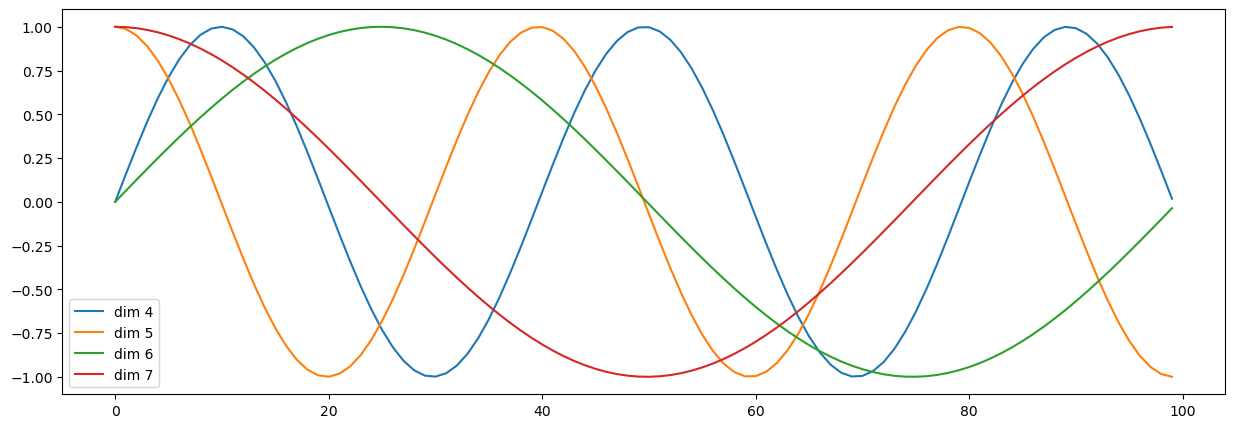

In [11]:
plt.figure(figsize=(15,5))
pe = PositionalEncoding(20,0)
y = pe(Variable(torch.zeros(1,100,20)))
plt.plot(np.arange(100),y[0,:,4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

## 编码器

### 掩码张量

In [12]:
def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape),k=1).astype('uint8')
    return torch.from_numpy(1 - subsequent_mask)

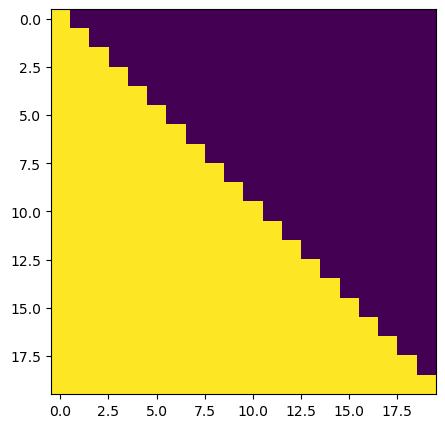

In [13]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])

### 注意力机制

In [14]:
def attention(query, key, value, mask=None, dropout=None):
    # 先取词嵌入维度
    d_k = query.size(-1)
    # 把key的最后两个维度进行转置，q和k的维度是(batch, sequence_length_q, features)和(batch, sequence_length_k, features)
    # 因此torch.matmul(query, key.transpose(-2, -1))的维度是(batch, sequence_length_q, sequence_length_k)
    scores = torch.matmul(query, key.transpose(-2, -1))/math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    # 对最后一维做softmax操作
    p_attn = F.softmax(scores, dim = -1)

    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [15]:
x = Variable(torch.randn(5,5))
x

tensor([[ 1.1597,  0.3693,  1.2259,  2.0038, -1.0100],
        [ 0.6366,  1.7863,  0.5159,  0.4086,  0.2834],
        [ 0.6558,  1.2876,  1.3928, -1.8047, -0.6794],
        [-0.1829,  0.9174, -0.6753,  1.2708,  0.8584],
        [ 0.4791, -0.8684,  0.2176,  1.1818, -0.6963]])

In [16]:
mask = Variable(torch.zeros(5,5))
mask

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [17]:
y = x.masked_fill(mask == 0, -1e9)
y

tensor([[-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09]])

In [18]:
query = key = value = pe_result
mask = Variable(torch.zeros(2,4,4))
attn, p_attn = attention(query, key, value,mask=mask)
print('attn', attn)
print(attn.shape)
print('p_attn', p_attn)
print(p_attn.shape)

attn tensor([[[ 22.3285,   0.1700,   4.3162,  ...,  -2.3716, -27.4857,  18.4639],
         [ 22.3285,   0.1700,   4.3162,  ...,  -2.3716, -27.4857,  18.4639],
         [ 22.3285,   0.1700,   4.3162,  ...,  -2.3716, -27.4857,  18.4639],
         [ 22.3285,   0.1700,   4.3162,  ...,  -2.3716, -27.4857,  18.4639]],

        [[ 22.5495, -12.8428,   1.3972,  ...,   5.1172,  13.4110,  19.2473],
         [ 22.5495, -12.8428,   1.3972,  ...,   5.1172,  13.4110,  19.2473],
         [ 22.5495, -12.8428,   1.3972,  ...,   5.1172,  13.4110,  19.2473],
         [ 22.5495, -12.8428,   1.3972,  ...,   5.1172,  13.4110,  19.2473]]],
       grad_fn=<UnsafeViewBackward0>)
torch.Size([2, 4, 512])
p_attn tensor([[[0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500]],

        [[0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
   

In [19]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [26]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, head, embedding_dim, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert embedding_dim % head == 0
        self.d_k = embedding_dim // head
        self.head = head
        # 多头注意力中Q, K, V需要线性层，最后多头合并后还需要线性层，因此一共需要4个线性层
        self.linears = clones(nn.Linear(embedding_dim, embedding_dim), 4)
        # 代码最后得到的注意力张量
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # 使用squeeze将掩码张量进行维度扩充，代表多头中的第n个头
            mask = mask.unsqueeze(1)
            
        batch_size = query.size(0)
        query, key, value = [model(x).view(batch_size, -1, self.head, self.d_k).transpose(1,2) for model, x in zip(self.linears, (query,key,value))]
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        x = x.transpose(1,2).contiguous().view(batch_size, -1, self.head*self.d_k)
        return self.linears[-1](x)

In [27]:
head = 8
embedding_dim = 512
dropout = 0.2

query = key = value = pe_result
mask = Variable(torch.zeros(2,4,4))
mha = MultiHeadedAttention(head, embedding_dim, dropout)
mha_result = mha(query, key, value, mask)
print(mha_result)
print(mha_result.shape)

tensor([[[10.2938, -3.2267,  3.6912,  ...,  0.3193, -2.3497, -3.1558],
         [ 6.8953, -6.8601,  0.4721,  ..., -2.3753,  2.2920, -6.3220],
         [13.6744, -6.5583,  0.3221,  ..., -3.7179,  5.1490, -6.5660],
         [13.3702, -6.7726, -7.1328,  ...,  0.1047,  1.5581, -9.2680]],

        [[ 4.5199, -1.7226, -0.7485,  ..., -0.1815,  7.2394, -9.2547],
         [ 5.5275, -3.9796,  0.3813,  ..., -0.7025,  8.1554, -8.6912],
         [ 7.8230, -0.6004,  6.3541,  ..., -3.0549,  6.6340, -0.9169],
         [ 1.0957, -3.7565, -2.4528,  ..., -3.1661,  7.3245, -8.8616]]],
       grad_fn=<ViewBackward0>)
torch.Size([2, 4, 512])


### 前馈全连接层

In [30]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w1 = nn.Linear(d_model, d_ff)
        self.w2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w2(self.dropout(F.relu(self.w1(x))))

In [31]:
d_model = 512
d_ff = 64
dropout = 0.2

x = mha_result
ff = PositionwiseFeedForward(d_model, d_ff, dropout)
ff_result = ff(x)
print(ff_result)
print(ff_result.shape)

tensor([[[ 0.8055,  0.4112, -0.3812,  ..., -0.9506,  0.0580, -0.9963],
         [ 0.6591,  0.2182, -0.6171,  ..., -2.0338, -0.7151,  0.3635],
         [ 1.2965,  0.3017, -1.4066,  ..., -2.0196,  1.1634,  0.7954],
         [ 0.0184,  0.2861, -1.1531,  ..., -1.7711,  0.6909,  1.2797]],

        [[ 0.8754,  0.2867, -1.1325,  ..., -2.2727,  0.9103,  1.9134],
         [ 1.0262,  1.9955, -0.6374,  ..., -2.1452,  2.1348,  1.9951],
         [ 0.9778,  0.9124, -0.6027,  ..., -1.7515,  1.0169,  1.2837],
         [ 1.1286,  0.5096, -1.7180,  ..., -2.8349,  1.2857,  1.5533]]],
       grad_fn=<ViewBackward0>)
torch.Size([2, 4, 512])


### 规范化层

In [34]:
class LayerNorm(nn.Module):
    # eps在规范化公式中作为分母出现，为防止分母是0，设置为1e-6
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a2 = nn.Parameter(torch.ones(features))
        self.b2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        # keepdim操作让张量只在数字上进行规范化，而不会改变形状
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a2 * (x - mean) / (std + self.eps) + self.b2

In [35]:
x = ff_result
ln = LayerNorm(512)
ln_result = ln(x)
print(ln_result)
print(ln_result.shape)

tensor([[[ 0.8757,  0.4892, -0.2874,  ..., -0.8454,  0.1431, -0.8903],
         [ 0.5503,  0.1916, -0.4880,  ..., -1.6407, -0.5677,  0.3098],
         [ 1.3137,  0.3563, -1.2878,  ..., -1.8778,  1.1857,  0.8315],
         [ 0.0557,  0.3723, -1.3296,  ..., -2.0604,  0.8509,  1.5471]],

        [[ 0.7827,  0.2255, -1.1176,  ..., -2.1967,  0.8157,  1.7651],
         [ 0.7195,  1.4772, -0.5809,  ..., -1.7596,  1.5860,  1.4769],
         [ 1.0347,  0.9627, -0.7054,  ..., -1.9702,  1.0777,  1.3716],
         [ 0.9586,  0.4048, -1.5883,  ..., -2.5876,  1.0992,  1.3386]]],
       grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


### 子层连接结构

In [ ]:
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout=0.1):
        